## read in the data

In [1]:
import os
print(os.getcwd())

# data_dir = os.getcwd()+"/paper/"
# print(data_dir)

os.chdir("/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo")

from examples.paper.initialize import *
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from IPython.display import HTML
from tqdm import tqdm_notebook

data_name = 'givemecredit'
data_file = data_dir / ('%s/cs-training.csv' % (data_name))

output_dir = results_dir / data_name
raw_df = pd.concat([pd.read_csv(data_file, index_col=0), ])

/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo/examples


In [2]:
raw_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,...,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,...,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,...,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,...,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,...,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,...,7,0,1,0,0.0


In [3]:
raw_df.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

In [8]:
raw_df['Age_cat'] = pd.cut(raw_df['age'], bins=[0, 25, 40, 59, 109])

In [9]:
raw_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,...,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Age_cat
1,1,0.766127,45,2,0.802982,...,0,6,0,2.0,"(40, 59]"
2,0,0.957151,40,0,0.121876,...,0,0,0,1.0,"(25, 40]"
3,0,0.658180,38,1,0.085113,...,1,0,0,0.0,"(25, 40]"
4,0,0.233810,30,0,0.036050,...,0,0,0,0.0,"(25, 40]"
5,0,0.907239,49,1,0.024926,...,0,1,0,0.0,"(40, 59]"


In [10]:
data_df = raw_df.drop(['age'], axis=1).copy()

y = 1 - raw_df['SeriousDlqin2yrs'].reset_index(drop=True)
X = (raw_df.drop(['SeriousDlqin2yrs', 'age', 'Age_cat'], axis=1)
            .fillna(0).reset_index(drop=True))

In [23]:
data_df.groupby(['Age_cat']).count()

,SeriousDlqin2yrs
Age_cat,
"(0, 25]",3027
"(25, 40]",32069
"(40, 59]",66585
"(59, 109]",48317


In [11]:
data_df.dtypes

SeriousDlqin2yrs                           int64
RevolvingUtilizationOfUnsecuredLines     float64
NumberOfTime30-59DaysPastDueNotWorse       int64
DebtRatio                                float64
MonthlyIncome                            float64
NumberOfOpenCreditLinesAndLoans            int64
NumberOfTimes90DaysLate                    int64
NumberRealEstateLoansOrLines               int64
NumberOfTime60-89DaysPastDueNotWorse       int64
NumberOfDependents                       float64
Age_cat                                 category
dtype: object

In [24]:
print(data_df.shape)
print(X.shape)

(149999, 2)
(150000, 9)


In [12]:
X.dtypes

RevolvingUtilizationOfUnsecuredLines    float64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

## train classifier

In [13]:
## train
clf = (
    LogisticRegressionCV(max_iter=1000, Cs=100, cv=5)
        .fit(X, y)
)

## create actionset

In [16]:
# actionset
action_set = ActionSet(X=X)
action_set['NumberOfDependents'].mutable = False
action_set['DebtRatio'].step_direction = -1

## run audit

In [17]:
# median score
np.median(clf.predict_proba(X)[:, 1])

0.9349357629159141

In [18]:
# cache classifier
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]
action_set.align(coefficients=coefficients)

# audit
p = np.median(clf.predict_proba(X)[:, 1]) ## for now we'll set this to the median score, but we could set this to any threshold we want.
auditor = RecourseAuditor(
    action_set,
    coefficients = coefficients,
    intercept = intercept - (np.log(p / (1. - p))),
)
audit_results = auditor.audit(X = X)

In [27]:
data_df = pd.concat([data_df['Age_cat'], y], axis=1, join='inner')

print(data_df.groupby(['Age_cat']).count())

data_df.head()

           SeriousDlqin2yrs
Age_cat                    
(0, 25]                3027
(25, 40]              32069
(40, 59]              66585
(59, 109]             48317
       SeriousDlqin2yrs
count     149999.000000
mean           0.933166
std            0.249735
min            0.000000
25%            1.000000
50%            1.000000
75%            1.000000
max            1.000000


,Age_cat,SeriousDlqin2yrs
1,"(40, 59]",1
2,"(25, 40]",1
3,"(25, 40]",1
4,"(25, 40]",1
5,"(40, 59]",1


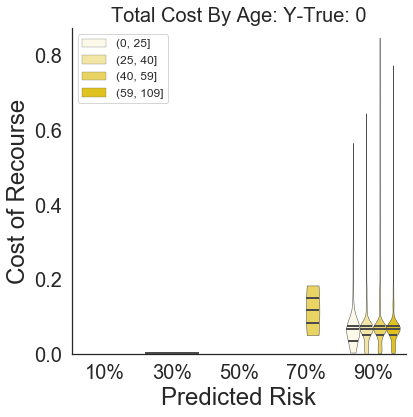

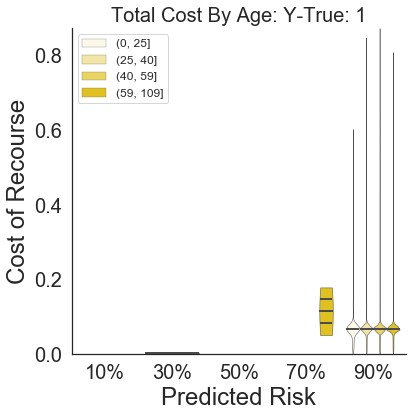

In [41]:
scores = pd.Series(clf.predict_proba(X)[:, 1])
matching_df = pd.concat([
    data_df,
    audit_results[['cost']],
    scores.to_frame('y_pred')
    ], axis=1).replace(np.inf, np.nan).dropna()

####### Matching 2: Control for Y=+/- 1
matching_df['y_pred_bin'] = pd.cut(
    matching_df['y_pred'],
    bins=np.arange(0, 1.1, .2)
)

# print(matching_df)

bins = matching_df['y_pred_bin'].unique()

# print(matching_df.groupby(['y_pred_bin']).count())

max_cost = matching_df['cost'].max()
plt.rc("font", size=20)
for y_true in [0, 1]:
    plt.figure(figsize=(6, 6))
    ax = sns.violinplot(
        x='y_pred_bin',  y='cost', hue='Age_cat',
        data=matching_df.loc[lambda df: df['SeriousDlqin2yrs'] == y_true].sort_values('Age_cat'),
        linewidth = 0.5, cut=0, background='white',
        scale='width',
        color='gold',
        inner='quartile'
    )
    ax.set_xticklabels(["10%", "30%", "50%", "70%", "90%"])
    
#     ax.set_axis_labels('<25', '25-40', '40-59','>60')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylim((0, max_cost))
    plt.title('Total Cost By Age: Y-True: %d' % y_true, fontsize=20)
    plt.ylabel('Cost of Recourse')
    plt.xlabel('Predicted Risk' )

#     if y_true == -1:
#         plt.legend(fontsize=12., loc='upper right', bbox_to_anchor=(1.1, 1))
#     else:
    plt.legend(fontsize=12., loc='upper left') #, bbox_to_anchor=(1, 1))
#     ax.legend(['<25', '25-40', '40-59','>60'], hue='Age', color='gold')
    
    
    for l in ax.lines:
        l.set_linewidth(2.)
        l.set_linestyle('-')
        l.set_solid_capstyle('butt')
        
#     sns.plt.show()
    plt.show() 

In [43]:
matching_df.groupby(['y_pred_bin', 'Age_cat']).count()

SeriousDlqin2yrs     cost   y_pred
y_pred_bin Age_cat                                      
(0.0, 0.2] (0, 25]                 NaN      NaN      NaN
           (25, 40]                NaN      NaN      NaN
           (40, 59]                NaN      NaN      NaN
           (59, 109]               NaN      NaN      NaN
(0.2, 0.4] (0, 25]                 2.0      2.0      2.0
           (25, 40]               62.0     62.0     62.0
           (40, 59]              122.0    122.0    122.0
           (59, 109]              83.0     83.0     83.0
(0.4, 0.6] (0, 25]                 NaN      NaN      NaN
           (25, 40]                NaN      NaN      NaN
           (40, 59]                NaN      NaN      NaN
           (59, 109]               NaN      NaN      NaN
(0.6, 0.8] (0, 25]                 NaN      NaN      NaN
           (25, 40]                NaN      NaN      NaN
           (40, 59]                2.0      2.0      2.0
           (59, 109]               2.0      2.0      2.0
(0.8, 1.0] (0, 25]              1534.0   1534.0   1534.0
           (25, 40]            15755.0  15755.0  15755.0
           (40, 59]            33421.0  33421.0  33421.0
           (59, 109]           24014.0  24014.0  24014.0

In [34]:
matching_df.groupby(['Age_cat']).describe()

SeriousDlqin2yrs                                ...    y_pred  \
                     count      mean       std  min  25%  ...       min   
Age_cat                                                   ...             
(0, 25]             1536.0  0.908854  0.287910  0.0  1.0  ...  0.253507   
(25, 40]           15817.0  0.903585  0.295169  0.0  1.0  ...  0.226237   
(40, 59]           33545.0  0.909554  0.286823  0.0  1.0  ...  0.203162   
(59, 109]          24099.0  0.909830  0.286431  0.0  1.0  ...  0.217615   

                                                   
                25%       50%       75%       max  
Age_cat                                            
(0, 25]    0.922094  0.927927  0.931748  0.934933  
(25, 40]   0.921842  0.927973  0.931719  0.934935  
(40, 59]   0.921713  0.927863  0.931682  0.934936  
(59, 109]  0.921818  0.927873  0.931705  0.934936  

[4 rows x 24 columns]

In [45]:
## accuracy:
24014.0/matching_df.shape[0]

0.3201994746456525